In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn


from torch.utils.data import Dataset
from skimage import io
from pathlib import Path
from typing import List, Tuple, Dict
from collections.abc import Iterable

In [2]:
class TTLDataset(Dataset):
    def __init__(self, root_dir : str, transform=None):
        """
        Args:
            root_dir (str): Directory with all the images. left & right
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        assert isinstance(root_dir, str)

        self.root_dir = Path(root_dir)
        self.left_images, self.right_images = self.check_directories_and_get_images_paths(self.root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.right_images)

    def __getitem__(self, idx : int) -> Tuple[Dict, str]:

        left_img_path = self.left_images[idx]
        right_img_path = self.right_images[idx]
        
        left_image = io.imread(left_img_path)
        right_image = io.imread(right_img_path)

        sample = {'left': left_image, 'right': right_image}

        if self.transform:
            sample['left'] = self.transform(sample['left'])
            sample['right'] = self.transform(sample['right'])

        return sample, left_img_path.name # same label for both

    def check_directories_and_get_images_paths(self, root_dir):
        assert os.path.isdir(root_dir)

        _, dirs, _ = next(os.walk(root_dir))

        assert 'left' in dirs
        assert 'right' in dirs

        _, _, left_images = next(os.walk(root_dir / 'left'))
        _, _, right_images = next(os.walk(root_dir /'right'))

        assert len(left_images) > 0
        assert len(left_images) == len(right_images)

        return [root_dir / 'left' / f for f in left_images], [root_dir / 'right' / f for f in right_images]

In [3]:
dataset = TTLDataset("C:\\Users\\Amine\\Desktop\\TER\\positive-similarity\\data", transforms.ToTensor())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def get_architecture_dict(model : nn.Module) -> dict:
    return dict(model.named_modules())

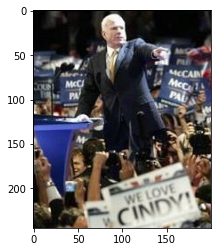

In [47]:
imshow(dataset[0][0]['left'])

In [5]:
class Test(nn.Module):
    def __init__(self):
        super().__init__()
        
        layers = []
        layers.append(nn.Sigmoid())
        layers.append(nn.Tanh())

        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

In [6]:
t = Test()
resnet18 = models.resnet18(pretrained=True)

In [44]:
# models = {'t' : t, 
#          'resnet18' : resnet18}

models = {'resnet18' : resnet18}

In [42]:
class FeatureExtractor:
    # TODO: find a way to save the out feature maps with their corresponding name rather than just a number
    """
        Extract images features using a given pretrained model[s].
        
        Create as many subdirs,
        
        save features in each dir
    """
    
    def __init__(self, save_path : str, models_dict : Dict, layers_indices : List = [-2]):
        assert isinstance(save_path, str)
        assert isinstance(models_dict, Dict)
        
        for model_name, model in models_dict.items():
            assert isinstance(model_name, str)
            assert isinstance(model, nn.Module)
            
        self.models = list(models_dict.values())
        self.save_path = Path(save_path)
        
        for model_name, model in models_dict.items():
            for layer_index in layers_indices:
                
                layer_name, module = list(model.named_modules())[layer_index]
                module.register_forward_hook(self.get_activation(model_name, layer_name))
        
    def get_activation(self, model_name, layer_name):
        
        def hook(model, inp, output):
            save_path = self.save_path / str(model_name) / str(layer_name)
            save_path.mkdir(parents=True, exist_ok=True)
            
            torch.save(output.detach(), save_path / (str(self.image_iterator) + '.pt'))
            
        return hook
    
    def extract_features(self, images : Iterable):
        assert len(images) > 0
        for img in images:
            assert isinstance(img, torch.Tensor)
        
        for model in self.models:
            self.image_iterator = 1
            for img in images:
                model(img.unsqueeze(0))
                self.image_iterator += 1
    
    def extract_features_ttl_dataset(self, dataset : TTLDataset):
        # special case here, because each datapoint is actually a pair of images
        assert len(dataset) > 0 and isinstance(dataset, TTLDataset)
        
        for model in self.models:
            self.image_iterator = 1
            for pair, label in dataset:
                left, right = pair.values()
                
                original_save_path = self.save_path
                
                self.save_path = original_save_path / 'left'
                model(left.unsqueeze(0))
                self.save_path = original_save_path / 'right'
                model(right.unsqueeze(0))
                
                self.image_iterator += 1
                self.save_path = original_save_path

extractor = FeatureExtractor("C:\\Users\\Amine\\Desktop\\test_hooks1", models, [-2])

In [43]:
extractor.extract_features([dataset[0][0]['left'], dataset[0][0]['right']])

In [14]:
extractor.extract_features_ttl_dataset(dataset)

KeyboardInterrupt: 